In [4]:
import json
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import IsolationForest
from collections import Counter

ImportError: No module named 'seaborn'

In [2]:
df = pd.read_csv('fdf_8_26_19.csv')

/Users/tylerhuntington222/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1124,1126,1129,1133,1134,1153,1203,1205,1208,1212,1213,1232,1277,1278,1279,1280,1281,1282,1283,1284,1285,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295,1296,1297,1298,1299,1300,1301,1302,1303,1304,1305,1306,1307,1308,1309,1310,1311,1312,1313,1314,1315,1316,1317,1318,1319,1320,1321,1346,1347,1348,1349,1350,1351,1352,1353,1354,1355,1356,1357,1376,1377,1378,1379,1380,1597,1598,1600,1601,1603,1615,1616,1617,1618,1619,1620,1621,1622,1623,1624,1625,1626,1793,1821,1822,1823,1824,1852) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


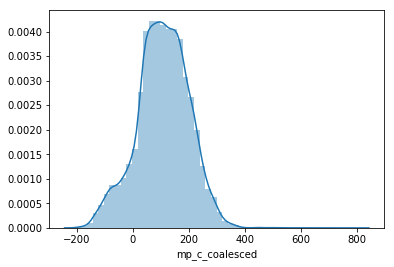

In [10]:
sns.distplot(df.mp_c_coalesced[~np.isnan(df.mp_c_coalesced)])

In [14]:
df.mp_c_coalesced.quantile(0.75)

170.0

In [36]:
def remove_outliers_by_iqr(df, target):
    q1 = df[target].quantile(0.25)
    q3 = df[target].quantile(0.75)
    iqr = q3 - q1
    lo_bound = q1 - 1.5 * iqr
    hi_bound = q3 + 1.5 * iqr
    df = df[(df[target] > lo_bound) & (df[target] < hi_bound)]
    return df

In [38]:
d = remove_outliers_by_iqr(df, 'mp_c_coalesced')

In [39]:
print(d.shape)
print(df.shape)

(20093, 1857)
(20849, 1857)


In [23]:
df.shape


(20849, 1857)

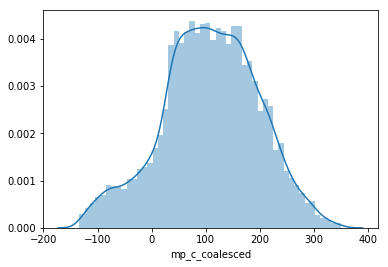

In [41]:
sns.distplot(d.mp_c_coalesced)

    dim_reduce_factors  mean_rmse_vals
18            0.000010       48.844210
9             0.005060       46.912669
17            0.010111       47.105667
6             0.015161       49.720402
12            0.020212       46.660592
14            0.025262       48.560155
5             0.030312       46.748307
1             0.035363       48.145517
20            0.040413       52.879734
3             0.045464       48.998517
15            0.050514       46.668141
19            0.055564       48.233405
10            0.060615       47.926995
11            0.065665       47.846412
13            0.070716       46.975953
2             0.075766       49.811937
21            0.080816       47.466655
4             0.085867       47.443093
7             0.090917       47.320547
16            0.095968       47.173948
8             0.101018       47.859715
22            0.106068       47.559014
0             0.111119       47.472363


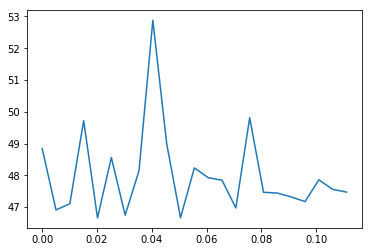

In [111]:
files = [f for f in os.listdir('../neural_net_exports/') if f.endswith('json')]
plot_mods = []
for f in files:
    try:
        with open(f'../neural_net_exports/{f}', 'r') as f:
            mdata = json.load(f)
    except json.JSONDecodeError:
        continue
    if mdata['n_epochs'] == 110:
        plot_mods.append(mdata)

plot_data = {
    'dim_reduce_factors': [],
    'mean_rmse_vals': []
}

for m in plot_mods:
    plot_data['dim_reduce_factors'].append(m['dim_reduce_factor'])
    rmse_vals = m['eval_metrics']['kfold_metrics']['fold_rmse_vals']
    rmse_vals.remove(max(rmse_vals))
    mean_rmse = np.mean(rmse_vals)
    plot_data['mean_rmse_vals'].append(mean_rmse)
plot_df = pd.DataFrame(plot_data).sort_values('dim_reduce_factors')
print(plot_df)

sns.lineplot(plot_data['dim_reduce_factors'], plot_data['mean_rmse_vals'])
     

In [113]:
# outlier detection
master_df = pd.read_csv('fdf_8_26_19.csv')

/Users/tylerhuntington222/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1124,1126,1129,1133,1134,1153,1203,1205,1208,1212,1213,1232,1277,1278,1279,1280,1281,1282,1283,1284,1285,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295,1296,1297,1298,1299,1300,1301,1302,1303,1304,1305,1306,1307,1308,1309,1310,1311,1312,1313,1314,1315,1316,1317,1318,1319,1320,1321,1346,1347,1348,1349,1350,1351,1352,1353,1354,1355,1356,1357,1376,1377,1378,1379,1380,1597,1598,1600,1601,1603,1615,1616,1617,1618,1619,1620,1621,1622,1623,1624,1625,1626,1793,1821,1822,1823,1824,1852) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [114]:
df = master_df
target = 'mp_c_coalesced'
dim_reduce_factor = 0.001
outlier_contam = 0.001

print('Shape of df before df.dropna(subset=[target]):')
print(df.shape)
df = df.dropna(subset=[target])
print('Shape of df after df.dropna(subset=[target]):')
print(df.shape)

# define feature cols
feat_cols = [c for c in df.columns if 'mordred_desc' in c]
feat_cols_to_drop = []

for f in feat_cols:
    df[f] = pd.to_numeric(df[f], errors='coerce')
    if len(df[f].unique()) == 1:
        # print(f'Dropping feature {f} with only one unique value')
        feat_cols_to_drop.append(f)

    if np.isnan(df[f]).sum()/df.shape[0] > dim_reduce_factor:
        feat_cols_to_drop.append(f)

    # if np.isnan(df[f]).any():
    #     print(f'Dropping feature {f} with NA values')
    #     print(df[f].unique())
    #     feat_cols_to_drop.append(f)


# re-construct list of feature columns with non-stationary features
tot_desc = len(feat_cols)
feat_cols = [f for f in feat_cols if f not in feat_cols_to_drop]
print(f'Using {len(feat_cols)}/{tot_desc} descriptors as features...')


Shape of df before df.dropna(subset=[target]):
(20849, 1857)
Shape of df after df.dropna(subset=[target]):
(20267, 1857)


/Users/tylerhuntington222/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using 783/1826 descriptors as features...


In [115]:
# drop rows with NA for any feature
print('Shape of df before df.dropna(subset=[feat_cols]):')
print(df.shape)
df = df.dropna(subset=feat_cols)
print('Shape of df after df.dropna(subset=[feat_cols)):')
df = df[[c for c in df.columns if c not in feat_cols_to_drop]]
print(df.shape)

# drop outliers
print(df.shape)
df = remove_outliers_by_iqr(df, target)
print(df.shape)

features = df.loc[:, feat_cols]

labels = df.loc[:, target]

Shape of df before df.dropna(subset=[feat_cols]):
(20267, 1857)
Shape of df after df.dropna(subset=[feat_cols)):
(20252, 814)
(20252, 814)
(20073, 814)


In [116]:
df = remove_outliers_by_isolation_forest(df, feat_colnames=feat_cols, contamination=0.0001)

/Users/tylerhuntington222/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


(20073, 814)
(20052, 814)
Isolation Forest with contamination factor of 0.001 removed 21 outliers


In [107]:
def remove_outliers_by_isolation_forest(df, feat_colnames, contamination):
    iso_for = IsolationForest(n_estimators=20, warm_start=True, contamination=contamination)
    iso_for.fit(features)
    ol_labs = iso_for.predict(df[feat_colnames])
    print(df.shape)
    df = df[ol_labs == 1]
    print(df.shape)
    counts = dict(Counter(ol_labs))
    print(f'Isolation Forest with contamination factor of {contamination} removed {counts[-1]} outliers')
    

In [120]:
list(np.linspace(0.001, 0.7, 20))

[0.001,
 0.037789473684210526,
 0.07457894736842105,
 0.11136842105263157,
 0.1481578947368421,
 0.18494736842105264,
 0.22173684210526315,
 0.25852631578947366,
 0.2953157894736842,
 0.33210526315789474,
 0.3688947368421053,
 0.40568421052631576,
 0.4424736842105263,
 0.47926315789473684,
 0.5160526315789473,
 0.5528421052631579,
 0.5896315789473684,
 0.6264210526315789,
 0.6632105263157895,
 0.7]